In [1]:
pip install astroquery

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from astroquery.gaia import Gaia 

<h2>Q2.1 - Q2.2: The process of crossmatching Gaia with 2MASS actually works in several steps.</h2>

<ul>
<li>tmass_psc_xsc_best_neighbour</li>
This table contains the “best match” between Gaia and 2MASS sources. However, it does not directly store the original 2MASS ID. Instead, it provides a cleaner and standardized identifier called <b>clean_tmass_psc_xsc_oid</b>

<li>tmass_psc_xsc_join</li>
This table functions as a bridge. It connects the clean identifier (clean_tmass_psc_xsc_oid) to the original 2MASS source ID, known as <b>original_psc_source_id</b>.
<br>
<li>tmass_original_valid</li>
Finally, this table provides the raw and complete data from 2MASS, including coordinates, error ellipses, and the official designation of the source.
</ul>


In [3]:
# --------------------------------------------------
#-----Q2.1 crossmatch with 2MASS catalogue ---------

query = f"""
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, xmatch.original_ext_source_id, xmatch.clean_tmass_psc_xsc_oid,tmass.tmass_oid, tmass.designation, 
tmass.ph_qual, gaia.bp_rp, gaia.phot_g_mean_mag, tmass.ks_m, tmass.j_m, tmass.h_m

FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass 
ON xjoin.original_psc_source_id = tmass.designation

WHERE 1=CONTAINS(
        POINT('ICRS', gaia.ra, gaia.dec),
        CIRCLE('ICRS', 289.074, -16.323, 1.0)
      )
  AND gaia.phot_g_mean_mag < 14

"""
job = Gaia.launch_job_async(query)
result = job.get_results()


#--------------------------------------------------------------------------
#---------Q2.2 how many stars are returned from the initial query----------

count_stars = len(result)
print("stars are returned from the initial query: ", count_stars)

INFO: Query finished. [astroquery.utils.tap.core]
stars are returned from the initial query:  3637


<h3>Q2.3- Q2.4:</h3>

<li>Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’</li>
<li>Identify any stars with negative (or non-positive) parallaxes in the Gaia data.</li>

In [4]:
import pandas as pd 

df = result.to_pandas()


good_phot = df[df['ph_qual'] == 'AAA']
df_final = good_phot[good_phot['parallax'] > 0] 

#Apply these two quality cuts
print("The remaining stars:", len(df_final))  

The remaining stars: 3535


<h3>Q2.5 - Q2.7:Using the remaining stars, generate a figure with two panels (1 point per panel)</h3>

<li>A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude</li>
Calculate the abosolute G magnitude : 
$M_G = G - 5\log d + 5$
where $d = \frac{1000}{Parallax}$ (parallax in miliarcseconds),
    <br>
so, 
$M_G = G - 5\log(\frac{1000}{Parallax}) + 5 $

<li>A 2MASS J-Ks vs. apparent H magnitude diagram.</li>
Since there is no J-K in the table, calculate it first. 


/tmp/ipykernel_15607/1519766062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['M_G'] = df_final['phot_g_mean_mag'] - 5*np.log10(1000/df_final['parallax']) + 5
/tmp/ipykernel_15607/1519766062.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['J_K'] = df_final['j_m'] - df_final['ks_m']


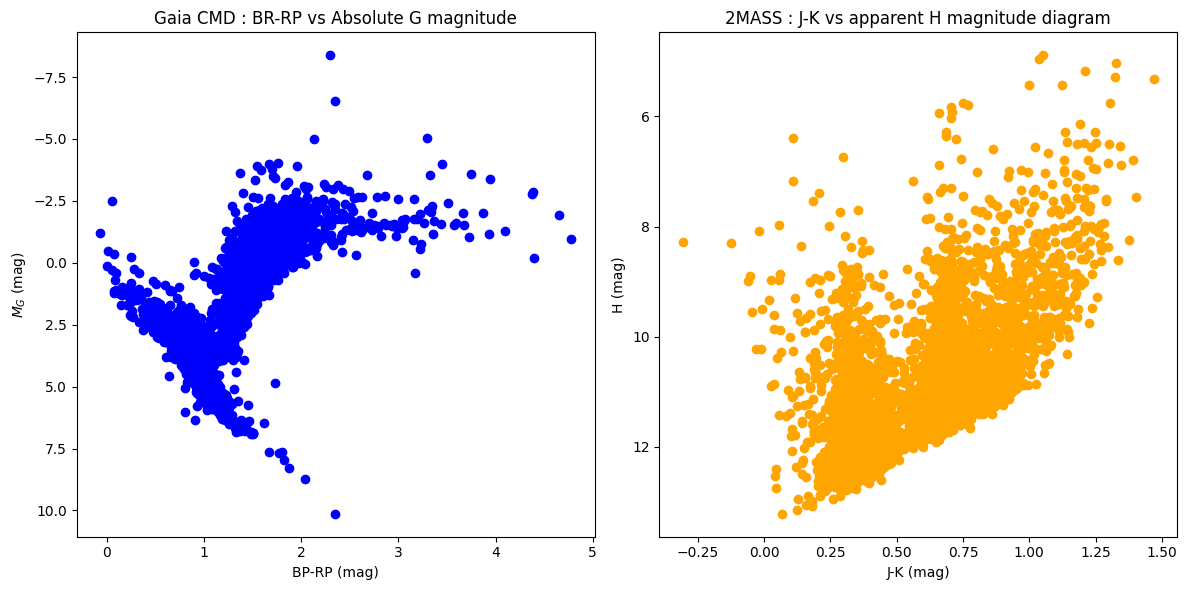

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import os 

os.makedirs('figures', exist_ok = True) #exist_ok = if the folder already exists, Python will not throw an error and will continue running normally

df_final['M_G'] = df_final['phot_g_mean_mag'] - 5*np.log10(1000/df_final['parallax']) + 5
df_final['J_K'] = df_final['j_m'] - df_final['ks_m']


#create a figure, nrow = 1, ncolumn = 2 (two panels, left and right)
fig, axes = plt.subplots(1,2,figsize=(12,6))

#Panel (a) : Gaia CMD 

axes[0].scatter(df_final['bp_rp'],df_final['M_G'], color = 'blue')
axes[0].invert_yaxis()  #everses the direction of the y-axis on a plot
axes[0].set_xlabel('BP-RP (mag)')
axes[0].set_ylabel('$M_G$ (mag)')
axes[0].set_title('Gaia CMD : BR-RP vs Absolute G magnitude')


#Panel (b) : 2MASS J-Ks vs. apparent H magnitude diagram

axes[1].scatter(df_final['J_K'],df_final['h_m'], color = 'orange')
axes[1].invert_yaxis()
axes[1].set_xlabel('J-K (mag)')
axes[1].set_ylabel('H (mag)')
axes[1].set_title('2MASS : J-K vs apparent H magnitude diagram')

plt.tight_layout() #preventing labels, titles, and other elements from overlapping
plt.savefig('figures/cmds R147.png', dpi=200) #dpi : Dots Per Inch
plt.show()

<h3>Q2.8</h3>
Give your colleague a recommendation for the potential proposal when only judging the fibre usage, that is, how many fibres of 2dF are available and would be used. 

The 2dF fibre positioner can allocate = 392 fibres in a single pointing. (https://aat.anu.edu.au/science/instruments/current/HERMES#:~:text=The%20HERMES%20system%20is%20built,current%20field%20is%20being%20observed.) 

After applying quality cuts, there are 3535 stars. The 2dF fibre positioner can observe 392 fibres per pointing, so we cannot observe all stars in a single pointing. To observe all 3535 stars, we need $\frac{3535}{392} = 9$ separate pointings.

The proposal should pick the most scientifically valuable targets for one pointing, or plan multiple pointings to cover all stars. 

In [6]:
pip install wget

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<h3>FITS files: </h3>

FITS (Flexible Image Transport System) is the standard data format in astronomy. 

A FITS file is made up of one or more HDUs (Header Data Units). 
Each HDU contains a HEADER (metadata) and DATA (image or table). 

- HDU[0]: Usually the "Primary HDU". It often stores an image or may be empty. 
- HDU[1], HDU[2], ...: Extensions that can store tables (columns and rows) or extra images. 

 To explore the structure:
  <li> hdul.info()   → shows all HDUs, their type, and dimensions </li>
    <li>hdul[i].header → shows metadata for HDU[i] </li>
   <li> hdul[i].data   → gives access to the actual data </li>

 Example:
<li> data = hdul[1].data</li>
<li>data.columns.names → list of column names</li>
<li>   data[0]            → first row</li>
<li>data['x']          → full column "x"</li>

 In summary: always check hdul.info() first to know what the file is composed of.


In [7]:
import wget 

if not os.path.exists('data'):
    os.makedirs('data')
output_directory = "/data"

#Check if the file exists
file_path = 'data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'
if not os.path.exists(file_path):

    #if not exists, then download the file
    # Do not use the GitHub "blob" link, as it points to an HTML page, not the raw file.
    # Always use the "raw.githubusercontent.com" link to download the actual FITS file.
    # Otherwise, astropy will raise "No SIMPLE card found" because it tries to read HTML.
    try:
        wget.download(
            url= "https://raw.githubusercontent.com/svenbuder/astr4004_2025_week8/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits",
            out=file_path
        ) 
    except Exception as e:
        raise RuntimeError(f"Could not download FITS file: {e}")
        


100% [....................................................] 10241280 / 10241280

slope: -0.03325, slope_err: 0.00002, 
 intercept:9.12232, intercept_err: 0.00028


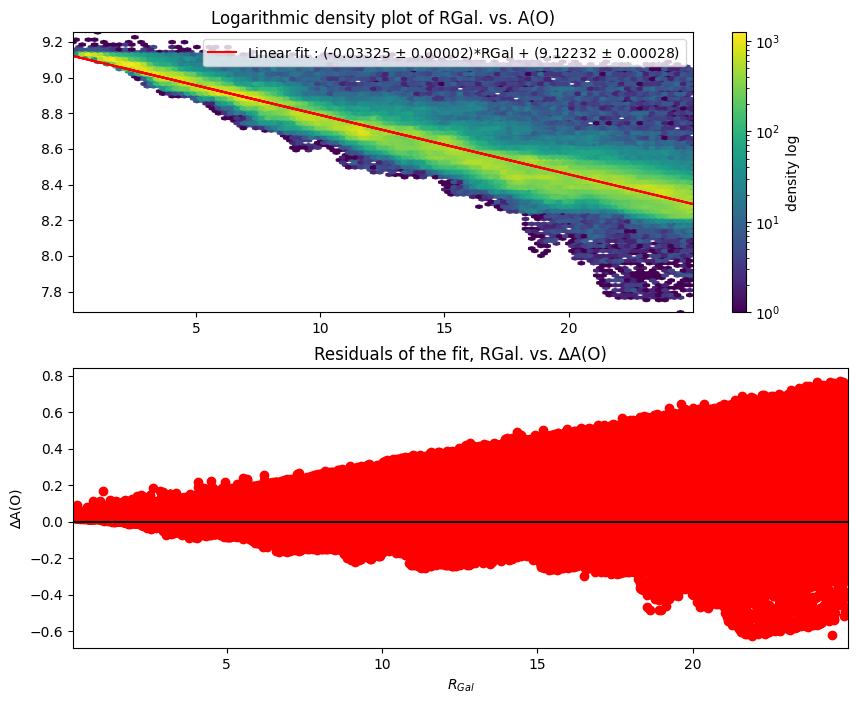

In [8]:
from scipy.optimize import curve_fit
from scipy import stats
from astropy.io import fits
fits_file = fits.open('data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')
#print(fits_file.info())

data = fits_file[1].data
#print(data.columns.names)

A_O = data['A_O']
x = data['x']
y = data['y']
z = data['z']

R_Gal = np.sqrt(x**2 + y**2 + z**2)

A_O_lim = A_O.min(), A_O.max()
R_Gal_lim = R_Gal.min(), R_Gal.max()

#Linear fit function 
def linear_func(R_Gal,slope,intercept):
    return slope*R_Gal+intercept #linear 


#Curve_fit : the function to find the best parameters to make linear_function fit the data as closely as possible 
#popt : the best parameters found by the fit. for linear function the parameters are: slope, intercept 
#pcov : covariance matrix, tell how uncertain each parameter is. smaller numbers mean the parameter more accurate
#pcov : is 2x2 matrix for lienar fit. accessing the diagonal gives the variance for each parameter
#np.diag--> [variance slope, variance intercept]
#np.sqrt --> uncertainty is the square root of variance 


popt,pcov = curve_fit(linear_func, R_Gal, A_O)
slope, intercept = popt
slope_err, intercept_err = np.sqrt(np.diag(pcov))
print(
    f"slope: {slope:.5f}, slope_err: {slope_err:.5f}, \n"
    f" intercept:{intercept:.5f}, intercept_err: {intercept_err:.5f}" )

A_O_fit = slope*R_Gal+intercept 
A_O_linfit = linear_func(R_Gal, slope, intercept)

#Residuals 
delta_AO = A_O - A_O_fit 

fig,axes = plt.subplots(2,1,figsize=(10,8))
hb = axes[0].hexbin(R_Gal, A_O, gridsize=100, bins='log', cmap='viridis') #logarithmic density plot 
axes[0].set(xlim=R_Gal_lim , ylim=A_O_lim) #set the limit for the axes
axes[0].set_title("Logarithmic density plot of RGal. vs. A(O)") 
cb = fig.colorbar(hb, ax=axes[0], label='density log') #set the color

#linear fit 
axes[0].plot(R_Gal, A_O_linfit, color = "red",label = f"Linear fit : ({slope:.5f} $\pm$ {slope_err:.5f})*RGal + ({intercept:.5f} $\pm$ {intercept_err:.5f})")
axes[0].legend()


#plot RGal vs delta_AO

axes[1].scatter(R_Gal, delta_AO, color = "red")
axes[1].set_xlim(R_Gal_lim)
axes[1].axhline(0,color = "black")
axes[1].set_xlabel("$R_{Gal}$")
axes[1].set_ylabel("∆A(O)")
axes[1].set_title("Residuals of the fit, RGal. vs. ∆A(O)")
plt.savefig('figures/plot RGal vs A(o) and the residual.png', dpi=200) #dpi : Dots Per Inch
plt.show()


From the residual plot, we can visually observe that for small values of $R_{Gal}$, the residuals are relatively small. This indicates that the linear fit describes the data quite well in this region. However, as $R_{Gal}$ increases, the residuals also become larger, indicating that the linear model is less suitable for describing the data at higher $R_{Gal}$ values. Quantitatively, this can be supported by statistical metrics: Root Mean Square Error (RMSE), which typically be lower in regions where the fit is good and higher where the residuals are larger. Below the calculation of RMSE and the plot

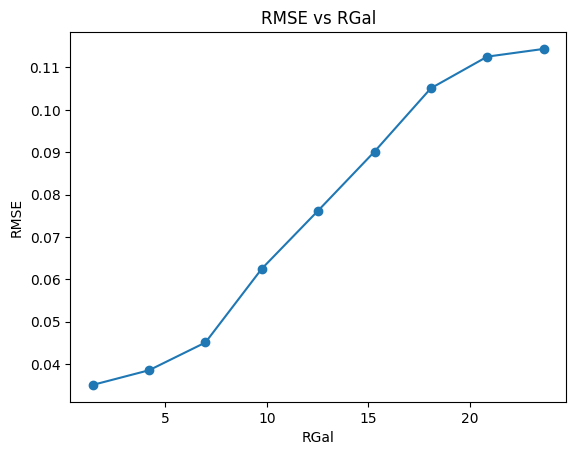

In [9]:
#We don’t want a single RMSE for all the data, but RMSE per radius. So we divide RGal into several bins (for example, every 1 kpc or 5 kpc).
#see how the fit error changes with radius
n_bins = np.linspace(R_Gal.min(), R_Gal.max(), 10)
rmse_perbin = []

for i in range(len(n_bins)-1):
    select_data = (R_Gal >= n_bins[i]) & (R_Gal < n_bins[i+1]) #select data in this bin
    delta = delta_AO[select_data]
    rmse = np.sqrt(np.mean(delta**2))
    rmse_perbin.append(rmse)

bincenter = (n_bins[:-1] + n_bins[1:])/2  # middle of each bin

plt.figure()
plt.plot(bincenter, rmse_perbin, marker = 'o')
plt.xlabel("RGal")
plt.ylabel("RMSE")
plt.title("RMSE vs RGal")
plt.savefig('figures/RMSE vs RGal.png', dpi=200) #dpi : Dots Per Inch
plt.show()
  

In [ ]:

#We have data x, y (gas positions in the galaxy) and A(O) (metallicity). 
#We want to make a map:Color shows the median A(O) in each small area (bin) in the XY plane.
# Small N_bins → big squares → lose detail
# Large N_bins → small squares → many empty bins, noisy

from scipy.stats import binned_statistic_2d 
import numpy as np 

list_bins = [10,50,100,200,500,1000]
for i, bins in enumerate(list_bins): 

    median_AO, xedges,yedges, binnumber = binned_statistic_2d(
        x,y,A_O, statistic = 'median', bins=bins)


    median_AOfit,xedges,yedges, binnumber = binned_statistic_2d(
        x,y,A_O_fit, statistic = 'median', bins=bins)


    median_deltaAO,xedges,yedges, binnumber = binned_statistic_2d(
        x,y,delta_AO, statistic = 'median', bins=bins)



#When we use imshow:
#We first cut the galaxy into a grid of squares 
#Each square --> we calculate the median metallicity of particles inside it
#So every square has a clear meaning: “in this exact region (this box), the median A(O) = X


#The array from binned_statistic_2d is stored as [x_bins, y_bins].
#But imshow interprets rows (first dimension) as y and columns (second dimension) as x.
#If we don’t use .T, the plot will look rotated or flipped, so the galaxy orientation is wrong

#By default, imshow uses pixel coordinates (0,1,2,…) for the axes.
#That means the x and y axes show bin numbers, not physical values.
#Adding extent=[x.min(), x.max(), y.min(), y.max()] ensures that the axes are labeled in the real units

    fig,axes = plt.subplots(1,3,figsize=(10,8))
    plot1 = axes[0].imshow(median_AO.T, origin='lower', extent=[xedges[0],xedges[-1],yedges[0], yedges[-1]], cmap='turbo')
    plt.colorbar(plot1, ax=axes[0],label="Median A(O)",orientation = 'horizontal')
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].set_title(f"Median A(O) bins = {bins}")

    plot2 = axes[1].imshow(median_AOfit.T, origin='lower', extent=[xedges[0],xedges[-1],yedges[0], yedges[-1]], cmap='turbo')
    plt.colorbar(plot2, ax=axes[1],label="Median_AO_fit",orientation = 'horizontal')
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].set_title(f"Median_AO_fit bins = {bins}")

    plot3 = axes[2].imshow(median_deltaAO.T, origin='lower', extent=[xedges[0],xedges[-1],yedges[0], yedges[-1]], cmap='turbo')
    plt.colorbar(plot3, ax=axes[2],label="Median_deltaAO",orientation = 'horizontal')
    axes[2].set_xlabel("X")
    axes[2].set_ylabel("Y")
    axes[2].set_title(f"Median_deltaAO bins = {bins}")


plt.tight_layout()
plt.savefig('figures/2D-histogram of the median AO.png', dpi=200) #dpi : Dots Per Inch
plt.show()


<h3>Q2.5</h3>

With too few bins (like 10 or 50), the squares are too big, so we lose details.
With too many bins (like 200, 500, or 1000), a lot of bins are empty, and the plots look noisy with white gaps.
I chose 100 bins because it balances detail and clarity: too few bins would make the spiral and small structures blurry, while too many bins would create empty squares.

<h3>Q2.6</h3>

- From the residual plot, we can visually observe that for small values of $R_{Gal}$, the residuals are relatively small. This indicates that the linear fit describes the data quite well in this region. However, as $R_{Gal}$ increases, the residuals also become larger, indicating that the linear model is less suitable for describing the data at higher $R_{Gal}$ values.

- A simple linear fit assumes the same slope everywhere, so it overestimates the drop in metallicity in the outer regions. 

- In a galaxy, the spiral arms are regions where stars are forming actively. These regions usually have higher metallicity because new stars produce metals, but when do a linear fit of metallicity vs RGal, we are assuming that metallicity changes smoothly and only depends on distance. 

- In the spiral arms → actual metallicity is higher than the linear model predicts → positive residuals
    